In [ ]:
import zipfile

zip_file_path = '/content/drive/MyDrive/nfuqnidsv2.zip'
destination_folder = '/content'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(destination_folder)

print('Files extracted to:', destination_folder)

Files extracted to: /content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Missing values in each column:
L4_SRC_PORT                    0
L4_DST_PORT                    0
PROTOCOL                       0
L7_PROTO                       0
IN_BYTES                       0
IN_PKTS                        0
OUT_BYTES                      0
OUT_PKTS                       0
TCP_FLAGS                      0
CLIENT_TCP_FLAGS               0
SERVER_TCP_FLAGS               0
FLOW_DURATION_MILLISECONDS     0
DURATION_IN                    0
DURATION_OUT                   0
MIN_TTL                        0
MAX_TTL                        0
LONGEST_FLOW_PKT               0
SHORTEST_FLOW_PKT              0
MIN_IP_PKT_LEN                 0
MAX_IP_PKT_LEN                 0
SRC_TO_DST_SECOND_BYTES        0
DST_TO_SRC_SECOND_BYTES        0
RETRANSMITTED_IN_BYTES         0
RETRANSMITTED_IN_PKTS          0
RETRANSMITTED_OUT_BYTES        0
RETRANSMITTED_OUT_PKTS         0
SRC_TO_DST_AVG_THROUGHPUT      0
DST_TO_SRC_AVG_THROUGHPUT      0
NUM_PKTS_UP_TO_128_BYTES       0
NUM_PKTS_128

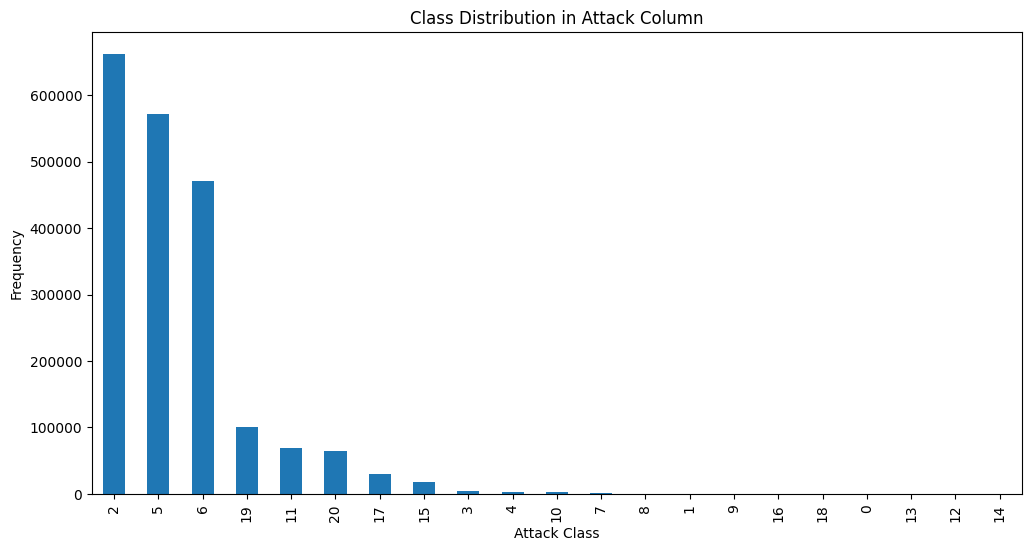

Class distribution after filtering:
Attack
2     661913
5     572211
6     470845
19    100396
11     68822
20     64571
17     30046
15     18143
3       3806
4       3371
10      3096
7        827
8        594
1        480
9        449
Name: count, dtype: int64
New class distribution after resampling:
Attack
6     18143
2     18143
19    18143
5     18143
20    18143
11    18143
17    18143
3     18143
8     18143
15    18143
4     18143
10    18143
7     18143
9     18143
1     18143
Name: count, dtype: int64


<ipython-input-4-db0d29b82805>:231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_centroids = torch.load('euc_final_centroids.pt')  # Load final centroids


Epoch 1/100 - Loss: 0.7741, Train Accuracy: 0.7379, Validation Accuracy: 0.7555
Epoch 6/100 - Loss: 0.3477, Train Accuracy: 0.8656, Validation Accuracy: 0.8532
Epoch 11/100 - Loss: 0.2916, Train Accuracy: 0.8873, Validation Accuracy: 0.8647
Epoch 16/100 - Loss: 0.2736, Train Accuracy: 0.8947, Validation Accuracy: 0.8668
Epoch 21/100 - Loss: 0.2490, Train Accuracy: 0.9063, Validation Accuracy: 0.8907
Epoch 26/100 - Loss: 0.2384, Train Accuracy: 0.9106, Validation Accuracy: 0.8854
Early stopping triggered


<ipython-input-4-db0d29b82805>:270: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('euc_protodemon.pt'))
<ipython-input-4-db0d29b82805>:271: 

Test Accuracy: 0.8924


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report

# Load the dataset
df = pd.read_csv('/content/NF-UQ-NIDS-v2.csv', nrows=2000000)  # Replace with your dataset path

pd.set_option('display.max_columns', None)

# Drop the IPV4 related columns
columns_to_drop = ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR']
df = df.drop(columns=columns_to_drop)

# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Handle missing values if any
df.dropna(inplace=True)

# Encode labels and map their original names
label_encoder = LabelEncoder()
df['Attack'] = label_encoder.fit_transform(df['Attack'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Select features and target
features = df.drop(columns=['Attack', 'Label', 'Dataset'])
target = df['Attack']

# Visualize class imbalance in the Attack column
attack_counts = df['Attack'].value_counts()
plt.figure(figsize=(12, 6))
attack_counts.plot(kind='bar')
plt.title('Class Distribution in Attack Column')
plt.xlabel('Attack Class')
plt.ylabel('Frequency')
plt.show()

# Filtering out underrepresented classes
class_counts = target.value_counts()
classes_to_keep = class_counts[class_counts >= 250].index  # Get classes with at least 250 samples
filtered_df = df[df['Attack'].isin(classes_to_keep)]

# Select features and target from the filtered DataFrame
features = filtered_df.drop(columns=['Attack', 'Label', 'Dataset'])
target = filtered_df['Attack']

scaler = MinMaxScaler()
features = scaler.fit_transform(features)

# Check the class distribution after filtering
print("Class distribution after filtering:")
print(target.value_counts())

# Ensure target is a DataFrame to maintain proper alignment
target_df = pd.DataFrame(target).reset_index(drop=True)

# Combine features and target into a single DataFrame for better handling
features_df = pd.DataFrame(features, columns=filtered_df.drop(columns=['Attack', 'Label', 'Dataset']).columns)
features_df['Attack'] = target_df

# Calculate the median sample size of the remaining classes
median_sample_size = target_df.value_counts().median()

# Create a new DataFrame to hold the balanced samples
balanced_df = pd.DataFrame()

# Create empty DataFrames to store the resampled data
undersampled_df = pd.DataFrame()
oversampled_features = []
oversampled_target = []

# Loop over each class and apply resampling
for attack_class in features_df['Attack'].unique():
    class_samples = features_df[features_df['Attack'] == attack_class]

    if len(class_samples) > median_sample_size:
        class_samples = resample(class_samples, n_samples=int(median_sample_size), random_state=42, replace=False)
        undersampled_df = pd.concat([undersampled_df, class_samples], ignore_index=True)
    else:
        oversampled_features.append(class_samples.drop(columns=['Attack']))
        oversampled_target.append(class_samples['Attack'])

# Combine oversampled data
if oversampled_features:
    oversampled_features = pd.concat(oversampled_features, ignore_index=True)
    oversampled_target = pd.concat(oversampled_target, ignore_index=True)

    smote = SMOTE(sampling_strategy='auto', k_neighbors=5, random_state=42)
    features_resampled, target_resampled = smote.fit_resample(oversampled_features, oversampled_target)

    smote_resampled_df = pd.DataFrame(features_resampled, columns=oversampled_features.columns)
    smote_resampled_df['Attack'] = target_resampled

    balanced_df = pd.concat([undersampled_df, smote_resampled_df], ignore_index=True)
else:
    balanced_df = undersampled_df

# Check the class distribution after resampling
print("New class distribution after resampling:")
print(balanced_df['Attack'].value_counts())

# Separate features and target
features_resampled = balanced_df.drop(columns=['Attack'])
target_resampled = balanced_df['Attack']

# Convert features and target to tensors
features_resampled_tensor = torch.tensor(features_resampled.values, dtype=torch.float32)
target_resampled_tensor = torch.tensor(target_resampled.values, dtype=torch.long)

# Adjust the target indices to ensure they range from 0 to num_classes-1
num_classes = target_resampled.nunique()
target_resampled = label_encoder.fit_transform(target_resampled)  # Ensure target labels are from 0 to n-1

# Adjust data types to ensure optimal performance
features_resampled = features_resampled.astype(np.float32)
target_resampled = target_resampled.astype(np.int64)

class NetworkTrafficDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features.values, dtype=torch.float32)  # Convert DataFrame to numpy array
        self.labels = torch.tensor(labels, dtype=torch.long)  # No .cuda()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

class ProtoNet(nn.Module):
    def __init__(self, input_dim, hid_dim, z_dim):
        super(ProtoNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hid_dim),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(hid_dim),
            nn.Dropout(0.5),
            nn.Linear(hid_dim, hid_dim // 2),
            nn.LeakyReLU(inplace=True),
            nn.BatchNorm1d(hid_dim // 2),
            nn.Dropout(0.5),
            nn.Linear(hid_dim // 2, z_dim)
        )

    def forward(self, x):
        return self.encoder(x)

# Custom Euclidean distance function
def euclidean_distance(x, y):
    return torch.sqrt(torch.sum((x - y) ** 2, dim=1))

def get_centroid(embeddings, labels, num_classes):
    centroids = []
    for i in range(num_classes):
        class_embeddings = embeddings[labels == i]
        centroid = class_embeddings.mean(dim=0)
        centroids.append(centroid)
    return torch.stack(centroids)

def train(model, optimizer, train_loader, scheduler, max_epoch, num_classes, val_loader):
    model.train()
    best_val_acc = 0.0
    best_epoch = 0  # Track the best epoch for early stopping
    for epoch in range(max_epoch):
        running_loss = 0.0
        running_acc = 0.0
        all_embeddings = []
        all_labels = []

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            embeddings = model(inputs)
            all_embeddings.append(embeddings)
            all_labels.append(labels)

            centroids = get_centroid(embeddings, labels, num_classes)
            distances = torch.stack([euclidean_distance(embedding, centroids) for embedding in embeddings]) + 1e-10
            loss = F.cross_entropy(-distances, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.min(distances, 1)
            running_acc += (predicted == labels).sum().item() / labels.size(0)

        scheduler.step()

        # Concatenate all embeddings and labels to calculate final centroids
        all_embeddings = torch.cat(all_embeddings)
        all_labels = torch.cat(all_labels)

        # Calculate final centroids and save them
        final_centroids = get_centroid(all_embeddings, all_labels, num_classes)
        torch.save(final_centroids, 'euc_final_centroids.pt')

        # Calculate validation accuracy
        val_acc = evaluate(model, val_loader, num_classes)

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch  # Update best epoch
            torch.save(model.state_dict(), 'euc_protodemon.pt')
        else:
            if epoch - best_epoch >= 5:
                print('Early stopping triggered')
                break

        if epoch % 5 == 0 or epoch == max_epoch - 1:
            print(f"Epoch {epoch + 1}/{max_epoch} - Loss: {running_loss / len(train_loader):.4f}, Train Accuracy: {running_acc / len(train_loader):.4f}, Validation Accuracy: {val_acc:.4f}")

def evaluate(model, test_loader, num_classes):
    model.eval()
    running_acc = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            embeddings = model(inputs)
            final_centroids = torch.load('euc_final_centroids.pt')  # Load final centroids
            distances = torch.stack([euclidean_distance(embedding, final_centroids) for embedding in embeddings]) + 1e-10
            _, predicted = torch.min(distances, 1)
            running_acc += (predicted == labels).sum().item() / labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return running_acc / len(test_loader)

# Set up the dataset and model parameters
input_dim = features_resampled.shape[1]
hid_dim = 256
z_dim = 128

# Create DataLoader instances for training and testing
dataset = NetworkTrafficDataset(features_resampled, target_resampled)
split_ratio = [0.6, 0.2, 0.2]  # Train, Val, Test split
train_size = int(len(dataset) * split_ratio[0])
val_size = int(len(dataset) * split_ratio[1])
test_size = len(dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create DataLoader instances with a batch size of 512
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)  # Increased batch size
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

# Initialize model, optimizer, and training parameters
model = ProtoNet(input_dim, hid_dim, z_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Train the model
max_epoch = 100
train(model, optimizer, train_loader, scheduler, max_epoch, num_classes, val_loader)

# Load the best model and test it
model.load_state_dict(torch.load('euc_protodemon.pt'))
final_centroids = torch.load('euc_final_centroids.pt')  # Load final centroids

# Test Accuracy
test_acc = evaluate(model, test_loader, num_classes)
print(f'Test Accuracy: {test_acc:.4f}')


In [ ]:
# Print the original labels and their corresponding encoded values
print("Original labels and their encoded values:")
for original_label, encoded_value in label_mapping.items():
    print(f"{encoded_value}: {original_label}")

Original labels and their encoded values:
0: Analysis
1: Backdoor
2: Benign
3: Bot
4: Brute Force
5: DDoS
6: DoS
7: Exploits
8: Fuzzers
9: Generic
10: Infilteration
11: Reconnaissance
12: Shellcode
13: Theft
14: Worms
15: injection
16: mitm
17: password
18: ransomware
19: scanning
20: xss


In [ ]:
def centroid_analysis(embeddings, labels, centroids, num_classes):
    intra_class_distances = []
    inter_class_distances = []

    for i in range(num_classes):
        class_embeddings = embeddings[labels == i]
        # Calculate intra-class distances
        distances = euclidean_distance(class_embeddings, centroids[i].unsqueeze(0))  # Add a batch dimension to centroids[i]
        intra_class_distances.append(torch.mean(distances).item())

        # Calculate inter-class distances
        for j in range(i + 1, num_classes):
            inter_class_distances.append(euclidean_distance(centroids[i].unsqueeze(0), centroids[j].unsqueeze(0)).item())

    return intra_class_distances, inter_class_distances

# Perform analysis
model.eval()
all_embeddings = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        embeddings = model(inputs)
        all_embeddings.append(embeddings)
        all_labels.append(labels)

all_embeddings = torch.cat(all_embeddings)
all_labels = torch.cat(all_labels)
intra_class_distances, inter_class_distances = centroid_analysis(all_embeddings, all_labels, final_centroids, num_classes)

print(f"Average intra-class distances: {np.mean(intra_class_distances)}")
print(f"Average inter-class distances: {np.mean(inter_class_distances)}")

Average intra-class distances: 10.99313767751058
Average inter-class distances: 24.827724266052247


Performing t-SNE on centroids and subset samples...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


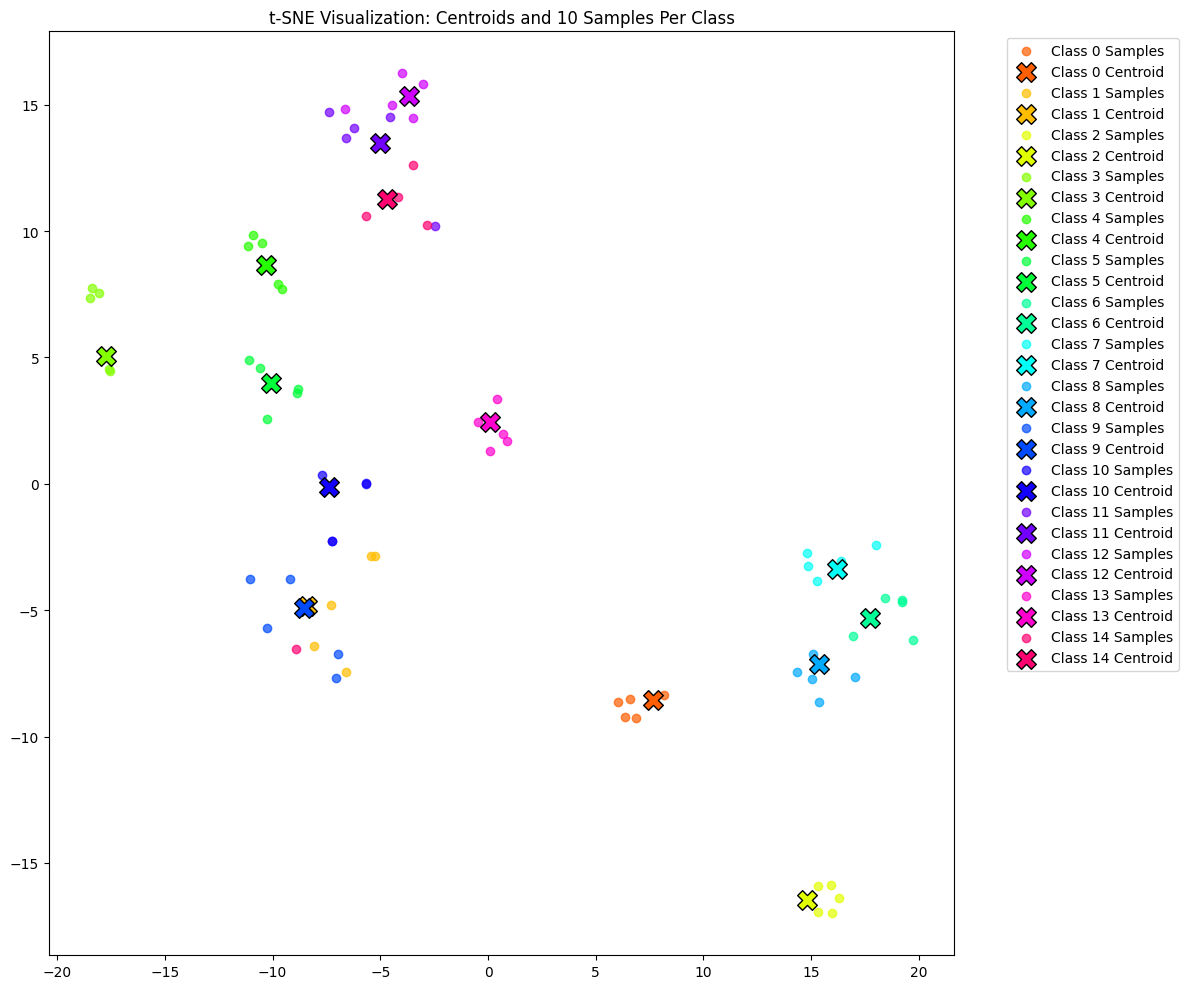

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Use a consistent color palette for better distinction
palette = sns.color_palette("hsv", num_classes)  # Generate unique colors for each class

# Select 10 samples per class and the centroids
samples_per_class = 5
subset_embeddings = []
subset_labels = []

# Collect 10 samples per class
for i in range(num_classes):
    class_indices = (test_labels == i).nonzero(as_tuple=True)[0]  # Indices of samples in class `i`
    selected_indices = class_indices[:samples_per_class]  # Select up to `samples_per_class` samples
    subset_embeddings.append(test_embeddings[selected_indices])
    subset_labels.append(test_labels[selected_indices])

# Concatenate the subset embeddings and labels
subset_embeddings = torch.cat(subset_embeddings)
subset_labels = torch.cat(subset_labels)

# Add centroids to the embeddings
subset_embeddings = torch.cat([subset_embeddings, final_centroids])
centroid_labels = torch.tensor(range(num_classes)) + num_classes  # Assign unique labels for centroids
subset_labels = torch.cat([subset_labels, centroid_labels])

# Detach embeddings before converting to NumPy
subset_embeddings_np = subset_embeddings.detach().cpu().numpy()

# Perform t-SNE on the subset embeddings and centroids
print("Performing t-SNE on centroids and subset samples...")
reduced_embeddings = TSNE(
    n_components=2,
    perplexity=10,  # Smaller value for the reduced subset
    n_iter=500,
    random_state=42
).fit_transform(subset_embeddings_np)

# Plot the t-SNE results
plt.figure(figsize=(12, 10))

# Plot samples and centroids for each class with matching colors
for i in range(num_classes):
    # Plot samples
    sample_indices = (subset_labels.cpu().numpy() == i)
    plt.scatter(
        reduced_embeddings[sample_indices, 0],
        reduced_embeddings[sample_indices, 1],
        label=f'Class {i} Samples',
        color=palette[i],
        alpha=0.7
    )

    # Plot centroid
    centroid_index = (subset_labels.cpu().numpy() == (i + num_classes))
    plt.scatter(
        reduced_embeddings[centroid_index, 0],
        reduced_embeddings[centroid_index, 1],
        label=f'Class {i} Centroid',
        color=palette[i],
        edgecolor='black',  # Highlight centroid points
        marker='X',
        s=200  # Larger size for centroids
    )

plt.title('t-SNE Visualization: Centroids and 10 Samples Per Class')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


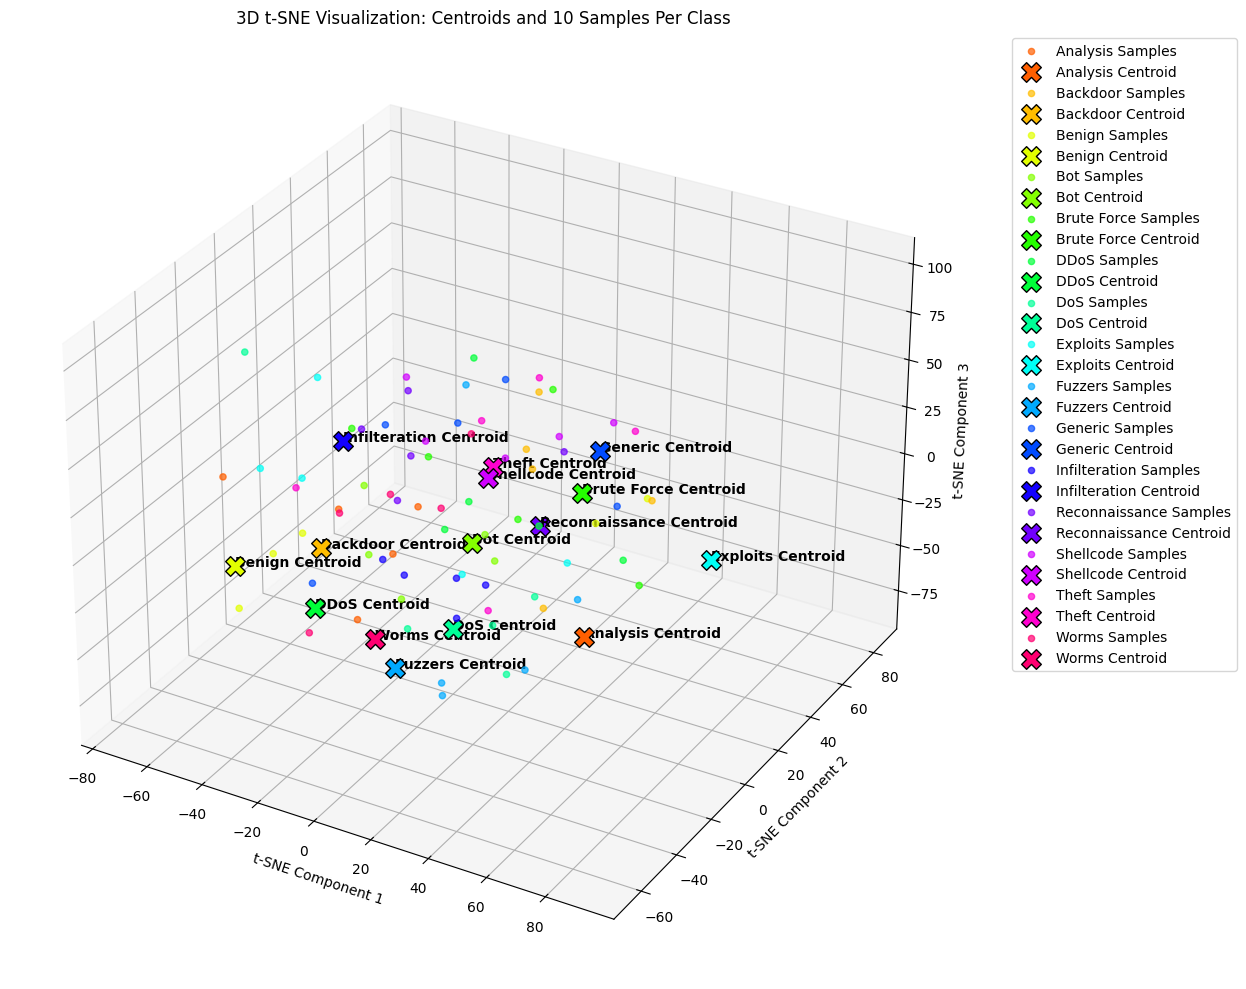

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.decomposition import PCA

# Assume you have the `label_mapping` dictionary from the encoding process
class_names = list(label_mapping.keys())  # List of original class names

# PCA pre-reduction to 30 components for faster t-SNE
pca_embeddings = PCA(n_components=30).fit_transform(subset_embeddings_np)

# 3D t-SNE transformation
reduced_embeddings = TSNE(
    n_components=3,
    perplexity=50,  # Adjust perplexity as needed
    n_iter=500,
    random_state=42
).fit_transform(pca_embeddings)

# Add jitter to centroids
jitter = np.random.normal(scale=0.1, size=(num_classes, 3))  # 3D jitter
for i in range(num_classes):
    centroid_index = (subset_labels.cpu().numpy() == (i + num_classes))
    reduced_embeddings[centroid_index] += jitter[i]

# 3D Plotting
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot samples and centroids
for i in range(num_classes):
    sample_indices = (subset_labels.cpu().numpy() == i)
    ax.scatter(
        reduced_embeddings[sample_indices, 0],
        reduced_embeddings[sample_indices, 1],
        reduced_embeddings[sample_indices, 2],
        label=f'{class_names[i]} Samples',
        color=palette[i],
        alpha=0.7
    )
    centroid_index = (subset_labels.cpu().numpy() == (i + num_classes))
    ax.scatter(
        reduced_embeddings[centroid_index, 0],
        reduced_embeddings[centroid_index, 1],
        reduced_embeddings[centroid_index, 2],
        label=f'{class_names[i]} Centroid',
        color=palette[i],
        edgecolor='black',
        marker='X',
        s=200
    )
    ax.text(
        reduced_embeddings[centroid_index, 0][0],
        reduced_embeddings[centroid_index, 1][0],
        reduced_embeddings[centroid_index, 2][0],
        f'{class_names[i]} Centroid',  # Add class name to the centroid text
        fontsize=10,
        color='black',
        fontweight='bold'
    )

# Set labels and title
ax.set_title('3D t-SNE Visualization: Centroids and 10 Samples Per Class')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

# Make sure the legend is visible and placed appropriately
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Show the plot
plt.tight_layout()
plt.show()


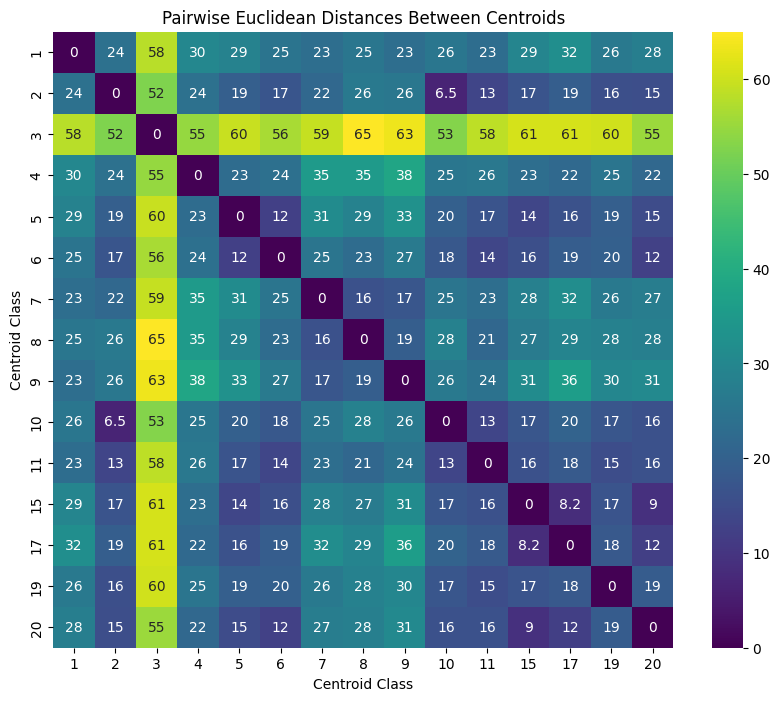

In [ ]:
from sklearn.metrics import pairwise_distances
import seaborn as sns

# Calculate pairwise Euclidean distances
distance_matrix = pairwise_distances(final_centroids.detach().numpy(), metric='euclidean')

# Plot heatmap of the distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix, annot=True, cmap='viridis', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Pairwise Euclidean Distances Between Centroids')
plt.xlabel('Centroid Class')
plt.ylabel('Centroid Class')
plt.show()


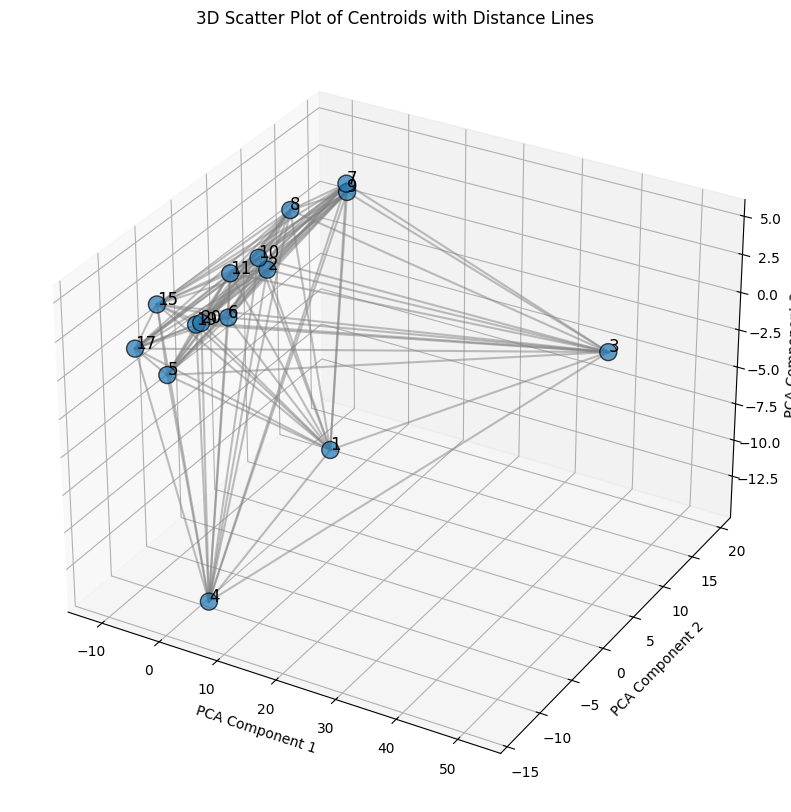

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Perform PCA for 3D visualization
pca = PCA(n_components=3)
centroids_3d = pca.fit_transform(final_centroids.detach().numpy())

# Create 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot centroids
ax.scatter(centroids_3d[:, 0], centroids_3d[:, 1], centroids_3d[:, 2], s=150, edgecolors='k', alpha=0.7)

# Add labels for each class
for i, label in enumerate(label_encoder.classes_):
    ax.text(centroids_3d[i, 0], centroids_3d[i, 1], centroids_3d[i, 2], label, size=12, color='black')

# Optionally, add lines connecting centroids (for visualizing distances)
for i in range(len(centroids_3d)):
    for j in range(i + 1, len(centroids_3d)):
        ax.plot([centroids_3d[i, 0], centroids_3d[j, 0]],
                [centroids_3d[i, 1], centroids_3d[j, 1]],
                [centroids_3d[i, 2], centroids_3d[j, 2]], color='gray', alpha=0.5)

ax.set_title('3D Scatter Plot of Centroids with Distance Lines')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.show()


<ipython-input-11-3e8d681755fd>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_centroids = torch.load('euc_final_centroids.pt')  # Load final centroids


Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.93      0.96      3608
           2       0.87      0.59      0.70      3656
           3       1.00      1.00      1.00      3623
           4       0.99      0.98      0.98      3602
           5       0.95      0.96      0.96      3600
           6       0.94      0.95      0.95      3498
           7       0.89      0.93      0.91      3676
           8       0.87      0.97      0.92      3694
           9       0.97      0.89      0.93      3663
          10       0.68      0.72      0.70      3678
          11       0.81      0.89      0.85      3712
          15       0.85      0.75      0.80      3581
          17       0.84      0.91      0.87      3589
          19       0.97      0.97      0.97      3587
          20       0.78      0.92      0.84      3662

    accuracy                           0.89     54429
   macro avg       0.89      0.89      0.89     54429
wei

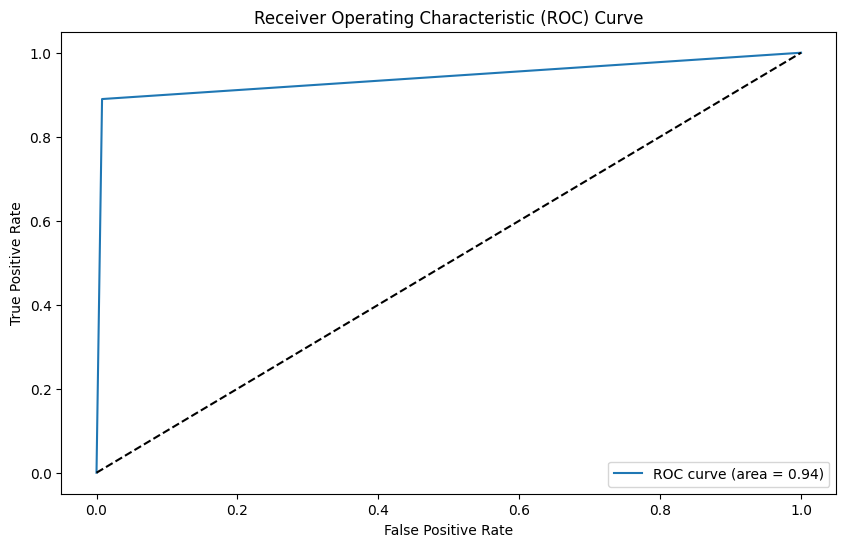

Confusion Matrix:
[[3360    0    0    0    0    0  108  101   37    0    2    0    0    0
     0]
 [   2 2140    0    4    3    1    5    1    1 1098  195    4    2   30
   170]
 [   0    0 3623    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   0    6    0 3528   67    0    0    0    0    0    0    0    0    1
     0]
 [   0    1    0   23 3457   14    0    0    0    0    2   67   13    1
    22]
 [   0    3    0    2   25 3331    4    2    0    4   14    0    0    0
   113]
 [   2    0    0    0    0    0 3414  214   46    0    0    0    0    0
     0]
 [   1    0    0    0    0    0  104 3565   24    0    0    0    0    0
     0]
 [   4    0    0    0    0    0  214  188 3256    0    1    0    0    0
     0]
 [   0  236    0    4    0    1    0    0    0 2666  505    2    0   13
   251]
 [   0   29    0    0    6  183    0   15    0   87 3310    4   13   59
     6]
 [   0    3    0    1   48    0    0    0    0    9   11 2682  508    2
   317]
 [   0    0    0    1 

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Evaluate on the test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        embeddings = model(inputs)
        final_centroids = torch.load('euc_final_centroids.pt')  # Load final centroids
        distances = torch.stack([euclidean_distance(embedding, final_centroids) for embedding in embeddings]) + 1e-10
        _, predicted = torch.min(distances, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Ensure that all_labels and all_preds are Python lists, not NumPy arrays
all_labels = list(all_labels)
all_preds = list(all_preds)

# Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

# Calculate AUC for each class (One-vs-Rest)
all_labels_bin = label_binarize(all_labels, classes=range(num_classes))  # One-hot encode labels
all_preds_bin = label_binarize(all_preds, classes=range(num_classes))  # One-hot encode predictions

# Calculate AUC scores
auc_scores = roc_auc_score(all_labels_bin, all_preds_bin, average='macro', multi_class='ovr')
print(f"AUC Score (macro-average): {auc_scores:.4f}")

# Compute the False Positive Rate and True Positive Rate for ROC curve
fpr, tpr, thresholds = roc_curve(all_labels_bin.ravel(), all_preds_bin.ravel())
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_scores)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Initialize an empty list to store False Positive Rate for each class
fpr_per_class = []

# Number of classes
num_classes = conf_matrix.shape[0]

# Compute FPR for each class
for i in range(num_classes):
    # False Positives are the sum of the column, excluding the diagonal (True Positives)
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    # True Negatives are the sum of all values excluding the current row and column
    tn = conf_matrix.sum() - conf_matrix[i, :].sum() - conf_matrix[:, i].sum() + conf_matrix[i, i]
    # Calculate False Positive Rate
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fpr_per_class.append(fpr)

# Display the False Positive Rate per class
for i, fpr in enumerate(fpr_per_class):
    print(f"False Positive Rate for class {label_encoder.classes_[i]}: {fpr:.4f}")


False Positive Rate for class 1: 0.0002
False Positive Rate for class 2: 0.0061
False Positive Rate for class 3: 0.0000
False Positive Rate for class 4: 0.0007
False Positive Rate for class 5: 0.0034
False Positive Rate for class 6: 0.0040
False Positive Rate for class 7: 0.0086
False Positive Rate for class 8: 0.0103
False Positive Rate for class 9: 0.0021
False Positive Rate for class 10: 0.0248
False Positive Rate for class 11: 0.0154
False Positive Rate for class 15: 0.0091
False Positive Rate for class 17: 0.0124
False Positive Rate for class 19: 0.0021
False Positive Rate for class 20: 0.0191


<ipython-input-25-d4c92c57dbf0>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_centroids = torch.load('euc_final_centroids.pt')  # Load final centroids


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.95      0.96      3573
     Class 1       0.89      0.56      0.68      3599
     Class 2       1.00      1.00      1.00      3582
     Class 3       1.00      0.98      0.99      3625
     Class 4       0.96      0.96      0.96      3708
     Class 5       0.94      0.95      0.94      3598
     Class 6       0.90      0.89      0.90      3673
     Class 7       0.88      0.91      0.89      3594
     Class 8       0.91      0.91      0.91      3657
     Class 9       0.60      0.83      0.70      3609
    Class 10       0.84      0.86      0.85      3659
    Class 11       0.73      0.80      0.76      3669
    Class 12       0.84      0.80      0.82      3627
    Class 13       0.96      0.97      0.97      3659
    Class 14       0.86      0.79      0.82      3597

    accuracy                           0.88     54429
   macro avg       0.89      0.88      0.88     54429
wei

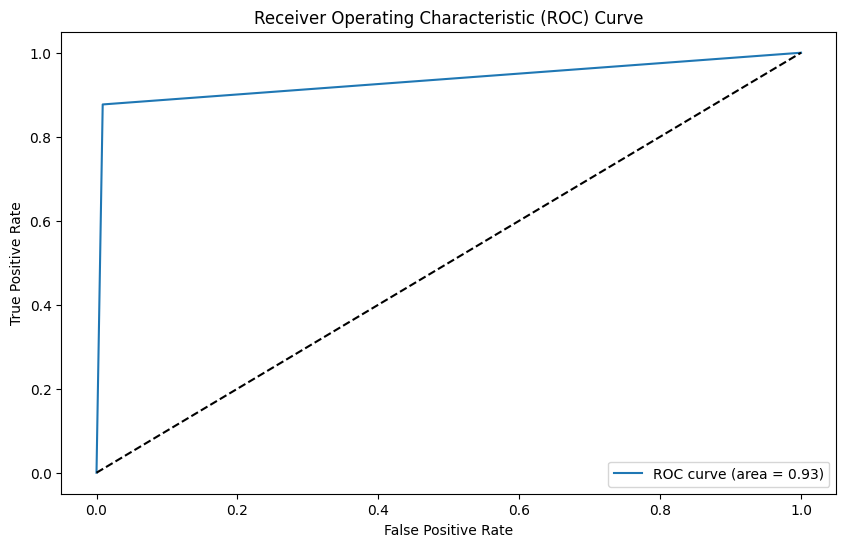

Confusion Matrix:


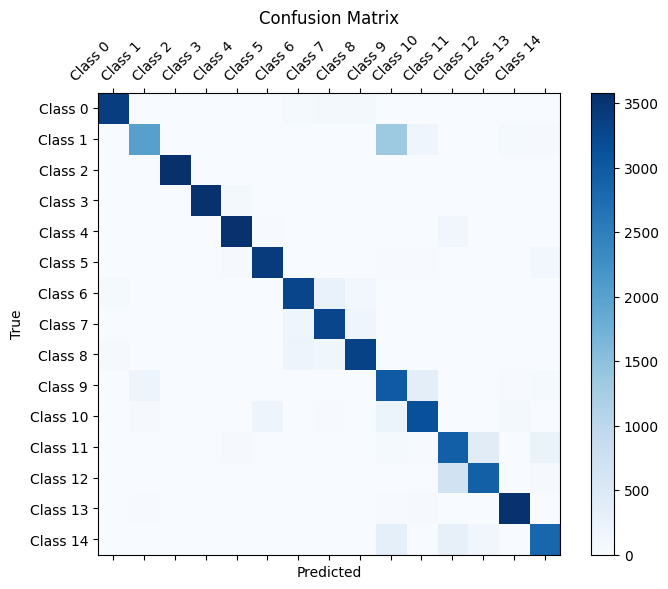

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Ensure `class_names` matches the number of classes
class_names = [f'Class {i}' for i in range(num_classes)]  # Adjust this as per your actual class names

# Evaluate on the test set
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        embeddings = model(inputs)
        final_centroids = torch.load('euc_final_centroids.pt')  # Load final centroids
        distances = torch.stack([euclidean_distance(embedding, final_centroids) for embedding in embeddings]) + 1e-10
        _, predicted = torch.min(distances, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Ensure that all_labels and all_preds are Python lists, not NumPy arrays
all_labels = list(all_labels)
all_preds = list(all_preds)

# Classification Report with class names
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, labels=list(range(num_classes))))  # Match labels

# Calculate AUC for each class (One-vs-Rest)
all_labels_bin = label_binarize(all_labels, classes=range(num_classes))  # One-hot encode labels
all_preds_bin = label_binarize(all_preds, classes=range(num_classes))  # One-hot encode predictions

# Calculate AUC scores
auc_scores = roc_auc_score(all_labels_bin, all_preds_bin, average='macro', multi_class='ovr')
print(f"AUC Score (macro-average): {auc_scores:.4f}")

# Compute the False Positive Rate and True Positive Rate for ROC curve
fpr, tpr, thresholds = roc_curve(all_labels_bin.ravel(), all_preds_bin.ravel())
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_scores)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix with class names
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
# Print the confusion matrix with the actual class names
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(conf_matrix, cmap='Blues')
fig.colorbar(cax)

ax.set_xticks(np.arange(num_classes))
ax.set_yticks(np.arange(num_classes))
ax.set_xticklabels(class_names, rotation=45, ha='right')
ax.set_yticklabels(class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Print the original labels and their corresponding encoded values
print("Original labels and their encoded values:")
for original_label, encoded_value in label_mapping.items():
    print(f"{encoded_value}: {original_label}")

Original labels and their encoded values:
0: Analysis
1: Backdoor
2: Benign
3: Bot
4: Brute Force
5: DDoS
6: DoS
7: Exploits
8: Fuzzers
9: Generic
10: Infilteration
11: Reconnaissance
12: Shellcode
13: Theft
14: Worms
15: injection
16: mitm
17: password
18: ransomware
19: scanning
20: xss


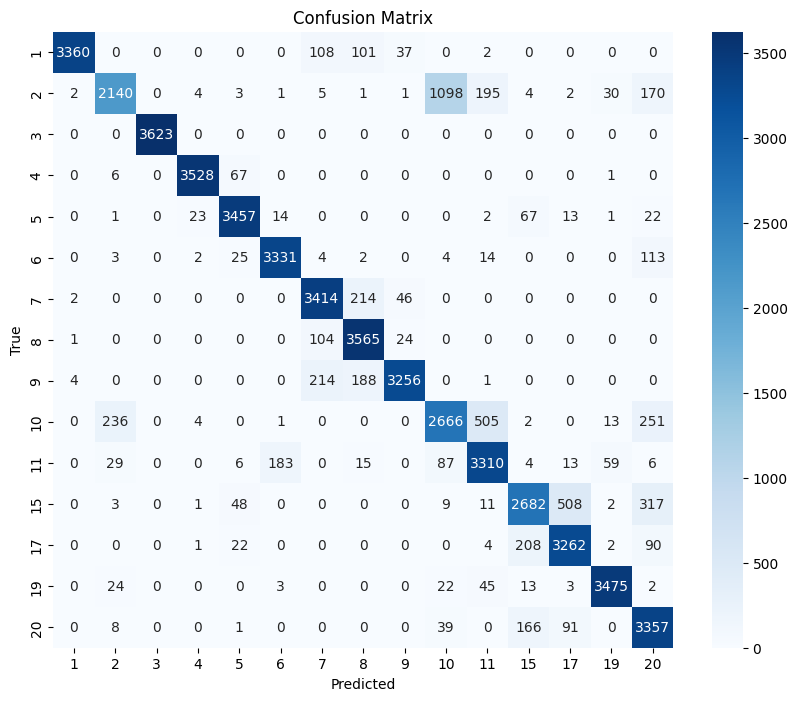

In [ ]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


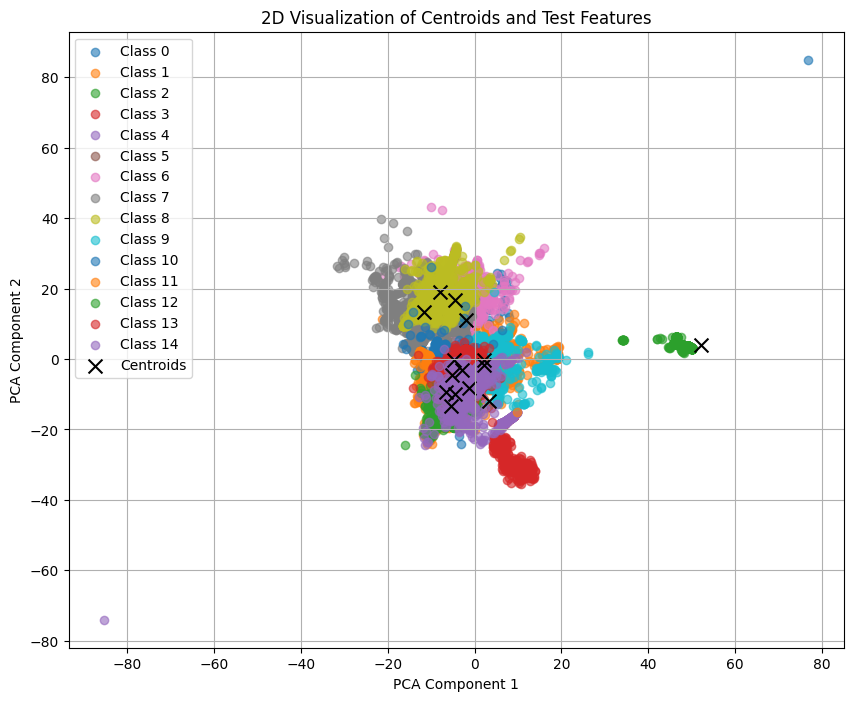

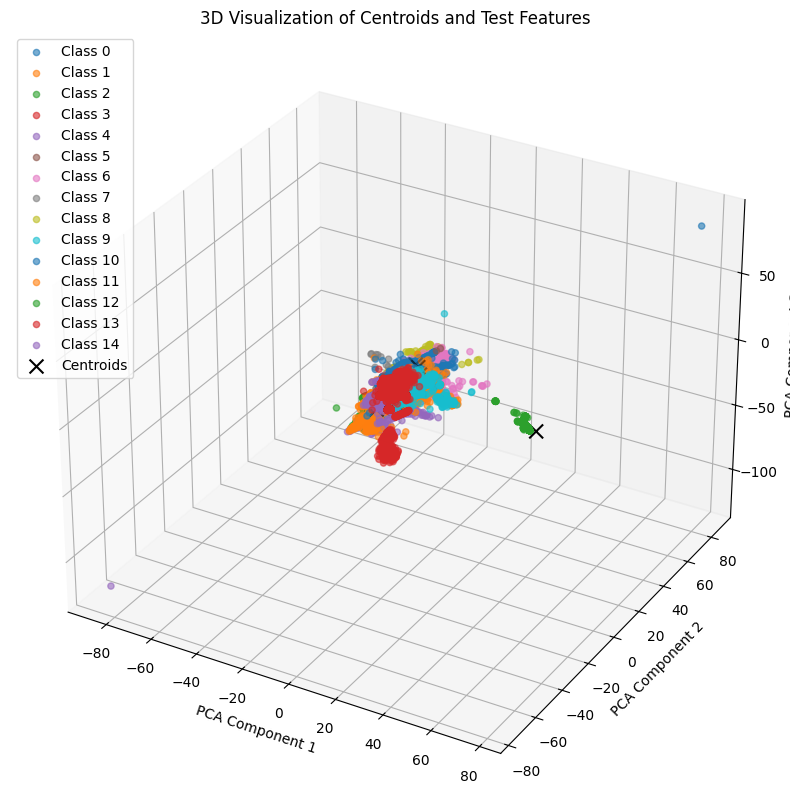

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Load the centroids and model
final_centroids = torch.load('euc_final_centroids.pt', weights_only=True)
model.load_state_dict(torch.load('euc_protodemon.pt', weights_only=True))
model.eval()

# Extract features and labels from the test set
test_features = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        embeddings = model(inputs)
        test_features.append(embeddings)
        test_labels.append(labels)

test_features = torch.cat(test_features).cpu().numpy()
test_labels = torch.cat(test_labels).cpu().numpy()

# Convert centroids to NumPy for visualization
centroids = final_centroids.detach().cpu().numpy()

# Combine centroids and test features for PCA
all_points = np.vstack((centroids, test_features))
pca = PCA(n_components=3)  # For 3D visualization
reduced_points = pca.fit_transform(all_points)

# Separate reduced centroids and reduced test points
reduced_centroids = reduced_points[:len(centroids)]
reduced_test_features = reduced_points[len(centroids):]

# 2D Visualization
plt.figure(figsize=(10, 8))
for class_id in range(num_classes):
    class_points = reduced_test_features[test_labels == class_id]
    plt.scatter(class_points[:, 0], class_points[:, 1], label=f'Class {class_id}', alpha=0.6)
plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], c='black', marker='x', s=100, label='Centroids')
plt.title('2D Visualization of Centroids and Test Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()

# 3D Visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
for class_id in range(num_classes):
    class_points = reduced_test_features[test_labels == class_id]
    ax.scatter(class_points[:, 0], class_points[:, 1], class_points[:, 2], label=f'Class {class_id}', alpha=0.6)
ax.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], reduced_centroids[:, 2], c='black', marker='x', s=100, label='Centroids')
ax.set_title('3D Visualization of Centroids and Test Features')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend()
plt.show()


<ipython-input-19-f74e594348d1>:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', num_classes)


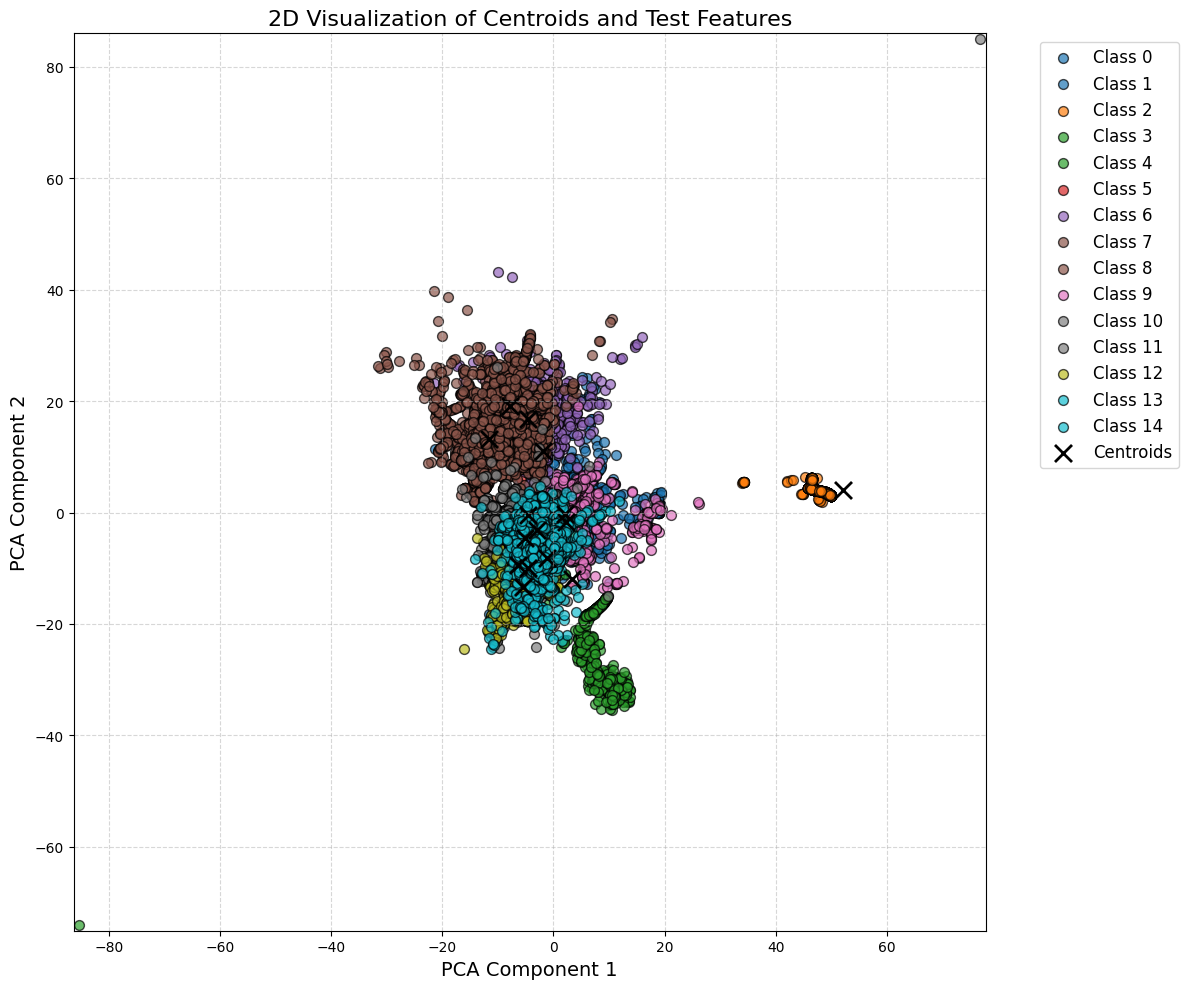

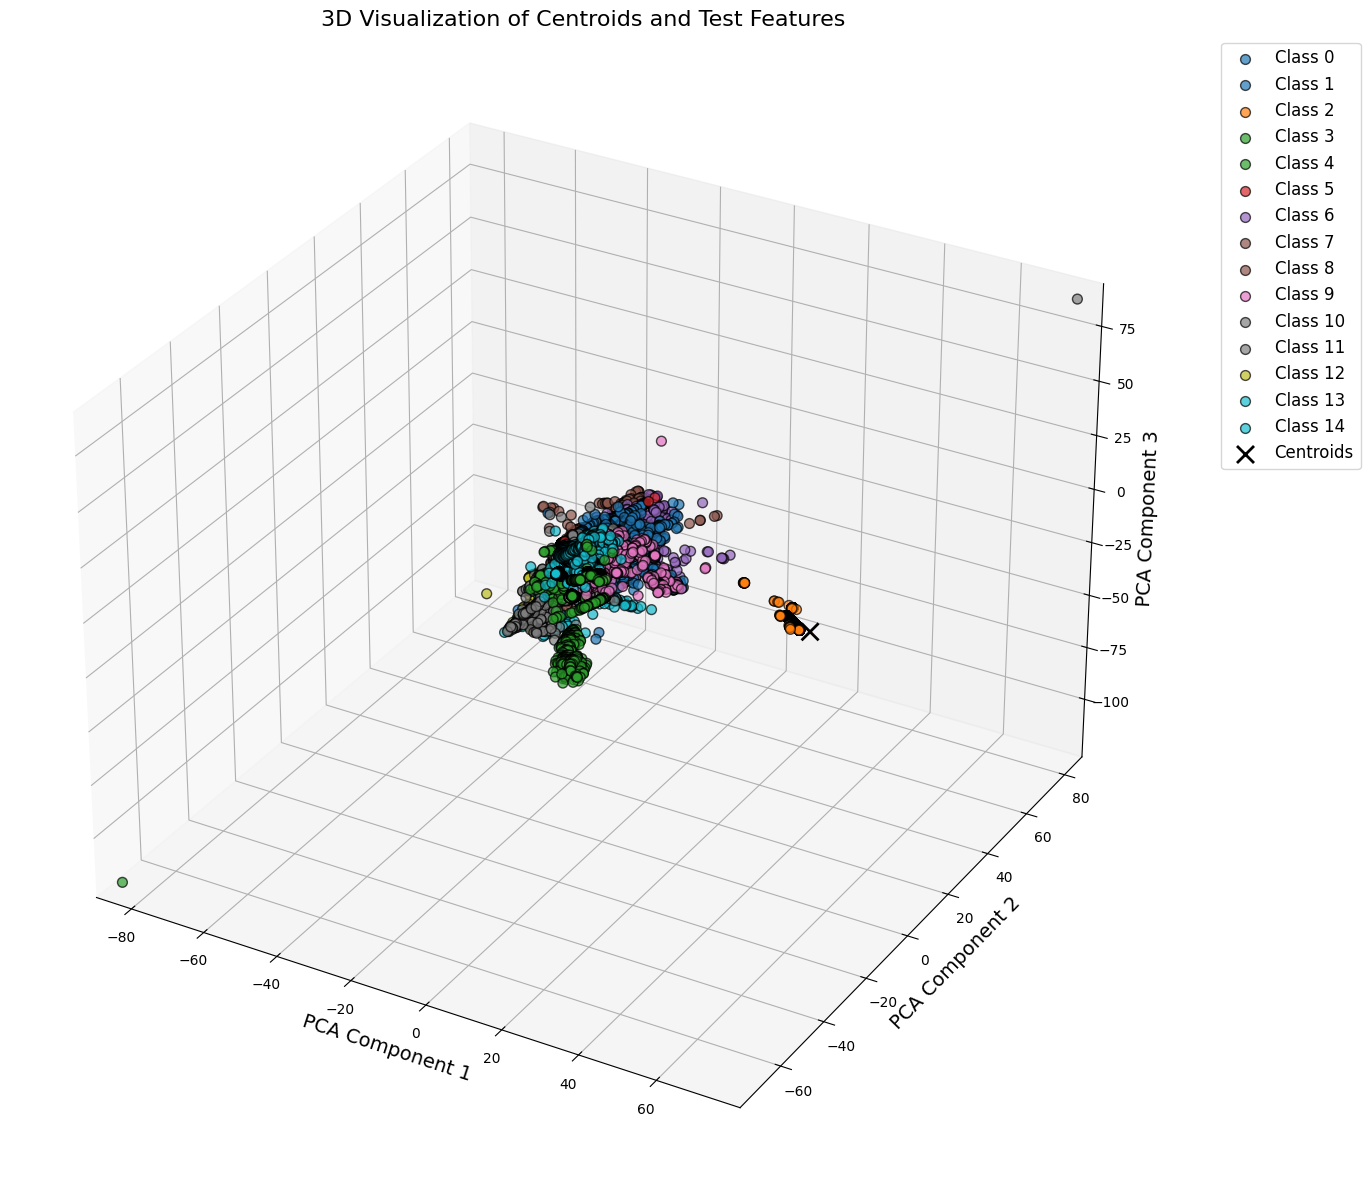

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# Load the centroids and model
final_centroids = torch.load('euc_final_centroids.pt', weights_only=True)
model.load_state_dict(torch.load('euc_protodemon.pt', weights_only=True))
model.eval()

# Extract features and labels from the test set
test_features = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        embeddings = model(inputs)
        test_features.append(embeddings)
        test_labels.append(labels)

test_features = torch.cat(test_features).cpu().numpy()
test_labels = torch.cat(test_labels).cpu().numpy()

# Convert centroids to NumPy for visualization
centroids = final_centroids.detach().cpu().numpy()

# Combine centroids and test features for PCA
all_points = np.vstack((centroids, test_features))
pca = PCA(n_components=3)  # For 3D visualization
reduced_points = pca.fit_transform(all_points)

# Separate reduced centroids and reduced test points
reduced_centroids = reduced_points[:len(centroids)]
reduced_test_features = reduced_points[len(centroids):]

# Set the number of classes based on your dataset
num_classes = len(np.unique(test_labels))

# 2D Visualization
plt.figure(figsize=(12, 10))

# Use a distinct color palette for classes
colors = plt.cm.get_cmap('tab10', num_classes)

for class_id in range(num_classes):
    class_points = reduced_test_features[test_labels == class_id]
    plt.scatter(class_points[:, 0], class_points[:, 1], label=f'Class {class_id}',
                color=colors(class_id), alpha=0.7, edgecolors='k', s=50)

# Plot centroids
plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], c='black', marker='x', s=150, label='Centroids', linewidths=2)

# Titles and labels
plt.title('2D Visualization of Centroids and Test Features', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('PCA Component 2', fontsize=14)

# Legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Adjust grid and limits
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlim(np.min(reduced_points[:, 0]) - 1, np.max(reduced_points[:, 0]) + 1)
plt.ylim(np.min(reduced_points[:, 1]) - 1, np.max(reduced_points[:, 1]) + 1)

plt.tight_layout()
plt.show()

# 3D Visualization
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

for class_id in range(num_classes):
    class_points = reduced_test_features[test_labels == class_id]
    ax.scatter(class_points[:, 0], class_points[:, 1], class_points[:, 2], label=f'Class {class_id}',
               color=colors(class_id), alpha=0.7, edgecolors='k', s=50)

# Plot centroids
ax.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], reduced_centroids[:, 2],
           c='black', marker='x', s=150, label='Centroids', linewidths=2)

# Titles and labels
ax.set_title('3D Visualization of Centroids and Test Features', fontsize=16)
ax.set_xlabel('PCA Component 1', fontsize=14)
ax.set_ylabel('PCA Component 2', fontsize=14)
ax.set_zlabel('PCA Component 3', fontsize=14)

# Legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Adjust grid and limits
ax.grid(True, linestyle='--', alpha=0.5)
ax.set_xlim(np.min(reduced_points[:, 0]) - 1, np.max(reduced_points[:, 0]) + 1)
ax.set_ylim(np.min(reduced_points[:, 1]) - 1, np.max(reduced_points[:, 1]) + 1)
ax.set_zlim(np.min(reduced_points[:, 2]) - 1, np.max(reduced_points[:, 2]) + 1)

plt.tight_layout()
plt.show()